In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.auto import tqdm

import argparse

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--epochs',type=int,default=20)
parser.add_argument('--batch_size',type=int,default=64)
parser.add_argument('--lr',type=float,default=0.001)
args = parser.parse_args(args=[])

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# GGul Tips

- einsum
- argparser in notebook
- how to metric learning

# Load Data

- CIFAR10

In [4]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


## DataSet and DataLoader

In [6]:
class AnchorPositivePairs(torch.utils.data.Dataset):
    def __init__(self, num_batchs, data, targets, img_shape: tuple, transform=None):
        self.num_batchs = num_batchs
        
        self.data = data
        self.targets = targets
        self.num_classes = len(np.unique(trainset.targets))
        self.img_shape = (img_shape[2], img_shape[0], img_shape[1])
        
        self.transform = transform
        
        self.class_idx_to_data_idxs = defaultdict(list)
        for y_data_idx, y in enumerate(self.targets):
            self.class_idx_to_data_idxs[y].append(y_data_idx)
        
    def __len__(self):
        return self.num_batchs
    
    def __getitem__(self, idx):
        anchors = torch.empty((self.num_classes,) + self.img_shape, dtype=torch.float32)
        positives = torch.empty((self.num_classes,) + self.img_shape, dtype=torch.float32)
        
        y = self.targets[idx]
        for class_idx in range(self.num_classes):
            # examples in class y_i
            examples_for_class = self.class_idx_to_data_idxs[class_idx]
        
            # random choice anchor index and positive index for anchor
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
        
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            
            # select anchor and positive image for anchor
            anchor = self.data[anchor_idx]
            positive = self.data[positive_idx]
            
            # transformation
            if self.transform!=None:
                anchor = self.transform(anchor)
                positive = self.transform(positive)
                
            anchors[class_idx] = anchor
            positives[class_idx] = positive

        
        return [anchors, positives]
            

In [7]:
# 0~1 minmax scaling
transform = transforms.Compose([
    transforms.ToTensor()
])

anchor_trainset = AnchorPositivePairs(num_batchs=1000,
                                      data=trainset.data,
                                      targets=trainset.targets,
                                      img_shape= trainset.data.shape[1:],
                                      transform=transform)


anchor_testset = AnchorPositivePairs(num_batchs=1000,
                                      data=testset.data,
                                      targets=testset.targets,
                                      img_shape= testset.data.shape[1:],
                                      transform=transform)

# Visualize Anchors and Positivies

In [8]:
def show_collage(examples):
    if isinstance(examples, list):
        examples = np.stack(examples, axis=1)
    num_rows = examples.shape[0]
    num_cols = examples.shape[1]

    f, ax = plt.subplots(num_rows, num_cols, figsize=(5*num_cols,5*num_rows))
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            ax[row_idx, col_idx].imshow(examples[row_idx][col_idx])
            ax[row_idx, col_idx].axis('off')

    plt.show()

In [9]:
examples = next(iter(anchor_trainset))

examples = np.transpose(np.stack(examples, axis=0), axes=[0,1,3,4,2])


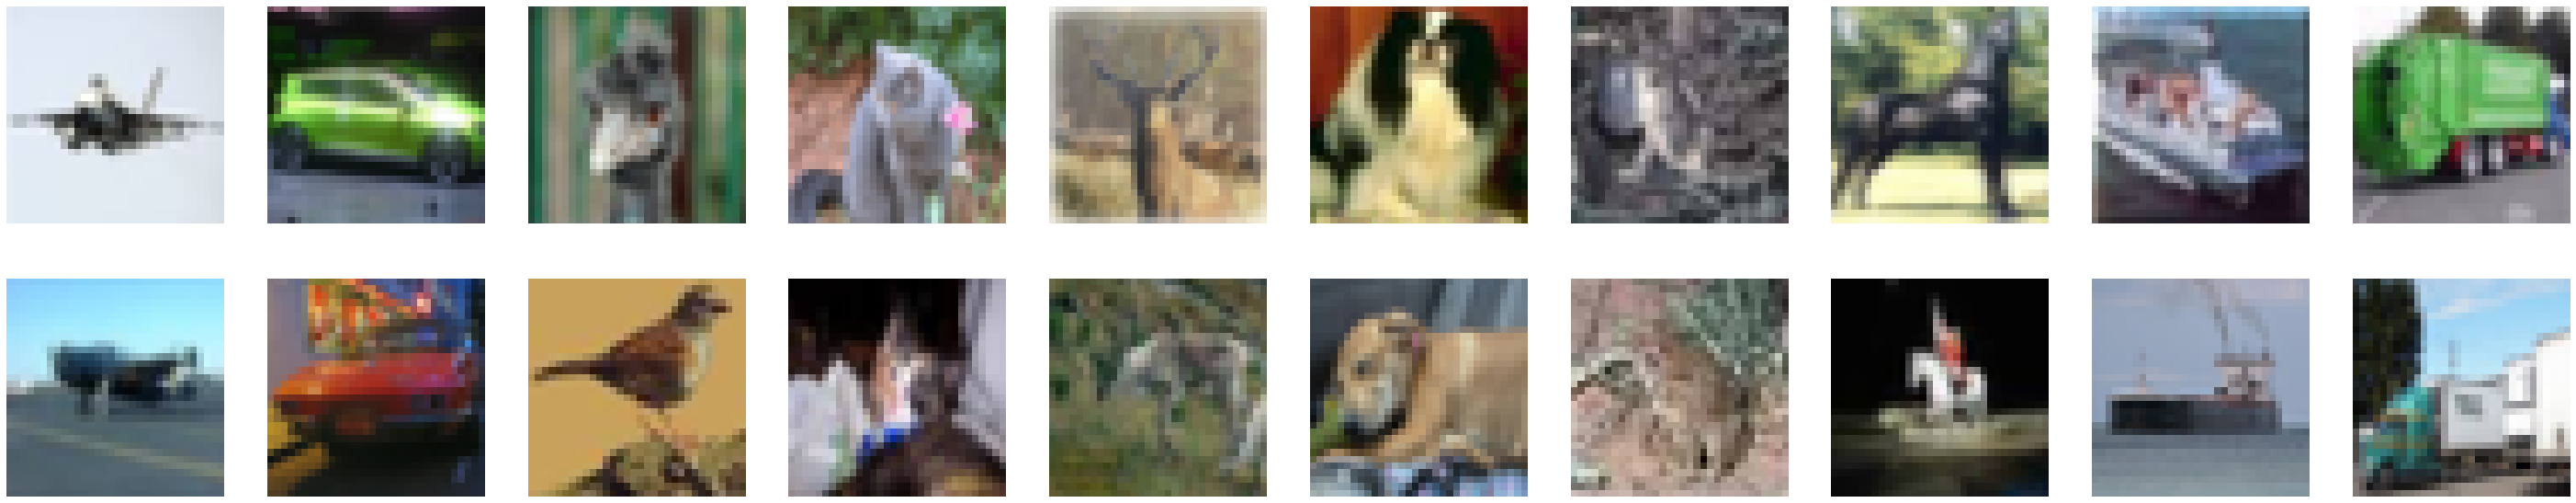

In [10]:
show_collage(examples)

# Build Model

In [11]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 2)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, 2)
        self.relu = torch.nn.ReLU()
        self.gap = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fcn = torch.nn.Linear(128, 8)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.relu(out)
        
        out = self.gap(out)
        
        out = self.fcn(out.view(out.size(0),-1))
        
        # l2 normalization
        out = torch.nn.functional.normalize(out, p=2, dim=1)
        
        return out

In [12]:
model = SimpleCNN().to(device)

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# Training

<p align='center'>
    <img src='https://user-images.githubusercontent.com/37654013/119249321-9444df80-bbd2-11eb-91e5-2a0f02504a48.png'>
</p>

In [14]:
def train(model, dataloader, criterion, optimizer, device):
    total_loss = 0
    for idx, inputs in enumerate(dataloader):
        if idx == len(dataloader):
            break
            
        anchors, positives = inputs[0].to(device), inputs[1].to(device)
        targets = torch.arange(anchors.shape[0]).to(device)

        # anchors_outputs (batch size x 8)
        anchors_outputs = model(anchors)
        # positives_outputs (batch size x 8)
        positives_outputs = model(positives)
        
        # inner product matrix
        # similarity (batch size x batch size)
        similarity = torch.einsum('ae,pe->ap',anchors_outputs, positives_outputs)
        
        # temperature, I don't know why the temperature needs in here 
        temperature = 0.2
        similarity /= temperature
        
        loss = criterion(similarity, targets)
        
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'[TRAIN {idx+1}/{len(dataloader)}] loss: {total_loss/(idx+1)}', end='\r')
    print()
        

In [15]:
def test(model, dataloader, criterion, optimizer, device):
    total_loss = 0
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            if idx == len(dataloader):
                break
                
            anchors, positives = inputs[0].to(device), inputs[1].to(device)
            
            targets = torch.arange(anchors.shape[0]).to(device)

            anchors_outputs = model(anchors)
            positives_outputs = model(positives)

            similarity = torch.einsum('ae,pe->ap',anchors_outputs, positives_outputs)
            temperature = 0.2

            similarity /= temperature

            loss = criterion(similarity, targets)

            total_loss += loss.item()
            
            print(f'[VALID {idx+1}/{len(dataloader)}] loss: {total_loss/(idx+1)}', end='\r')
        print()
        

In [16]:
for epoch in range(args.epochs):
    print(f'Epoch: {epoch+1}/{args.epochs}')
    train(model, anchor_trainset, criterion, optimizer, device)
    test(model, anchor_testset, criterion, optimizer, device)
    print()

Epoch: 1/20
[TRAIN 1000/1000] loss: 2.2534513465166093
[VALID 1000/1000] loss: 2.1878784116506576

Epoch: 2/20
[TRAIN 1000/1000] loss: 2.1404265990257265
[VALID 1000/1000] loss: 2.061614628314972

Epoch: 3/20
[TRAIN 1000/1000] loss: 2.0559389283657072
[VALID 1000/1000] loss: 2.0691391203403473

Epoch: 4/20
[TRAIN 1000/1000] loss: 2.005604639649391
[VALID 1000/1000] loss: 1.9836512594223021

Epoch: 5/20
[TRAIN 1000/1000] loss: 1.9838010671138764
[VALID 1000/1000] loss: 1.991712207555771

Epoch: 6/20
[TRAIN 1000/1000] loss: 1.9439043779373169
[VALID 1000/1000] loss: 1.9464486619234085

Epoch: 7/20
[TRAIN 1000/1000] loss: 1.9187811517715454
[VALID 1000/1000] loss: 1.9269798891544343

Epoch: 8/20
[TRAIN 1000/1000] loss: 1.903108273267746
[VALID 1000/1000] loss: 1.914440203666687

Epoch: 9/20
[TRAIN 1000/1000] loss: 1.8750740101337433
[VALID 1000/1000] loss: 1.8596017659902573

Epoch: 10/20
[TRAIN 1000/1000] loss: 1.842772526860237
[VALID 1000/1000] loss: 1.8585070288181305

Epoch: 11/20
[T

# Test

In [22]:
testset.transform = transform

In [23]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=128,
                                         shuffle=False)

In [25]:
near_neighbours_per_example = 10

embeddings = []
with torch.no_grad():
    for inputs, _ in tqdm(testloader):
        inputs = inputs.to(device)
        embeddings_i = model(inputs)
        
        embeddings.append(embeddings_i.cpu().numpy())

# embeddings (10000 x 8)        
embeddings = np.vstack(embeddings)

In [26]:
# gram_matrix (10000 x 10000)
gram_matrix = np.einsum('ae,be->ab', embeddings, embeddings)

# near_neighnours (10000 x 10)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1):]


In [27]:
num_collage_examples = 5

examples = np.empty(
    (num_collage_examples, near_neighbours_per_example + 1) + anchor_testset.data.shape[1:],
    dtype=np.uint8,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = anchor_testset.data[row_idx]
    anchor_near_neighbours = near_neighbours[row_idx][::-1][1:]
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = anchor_testset.data[nn_idx]

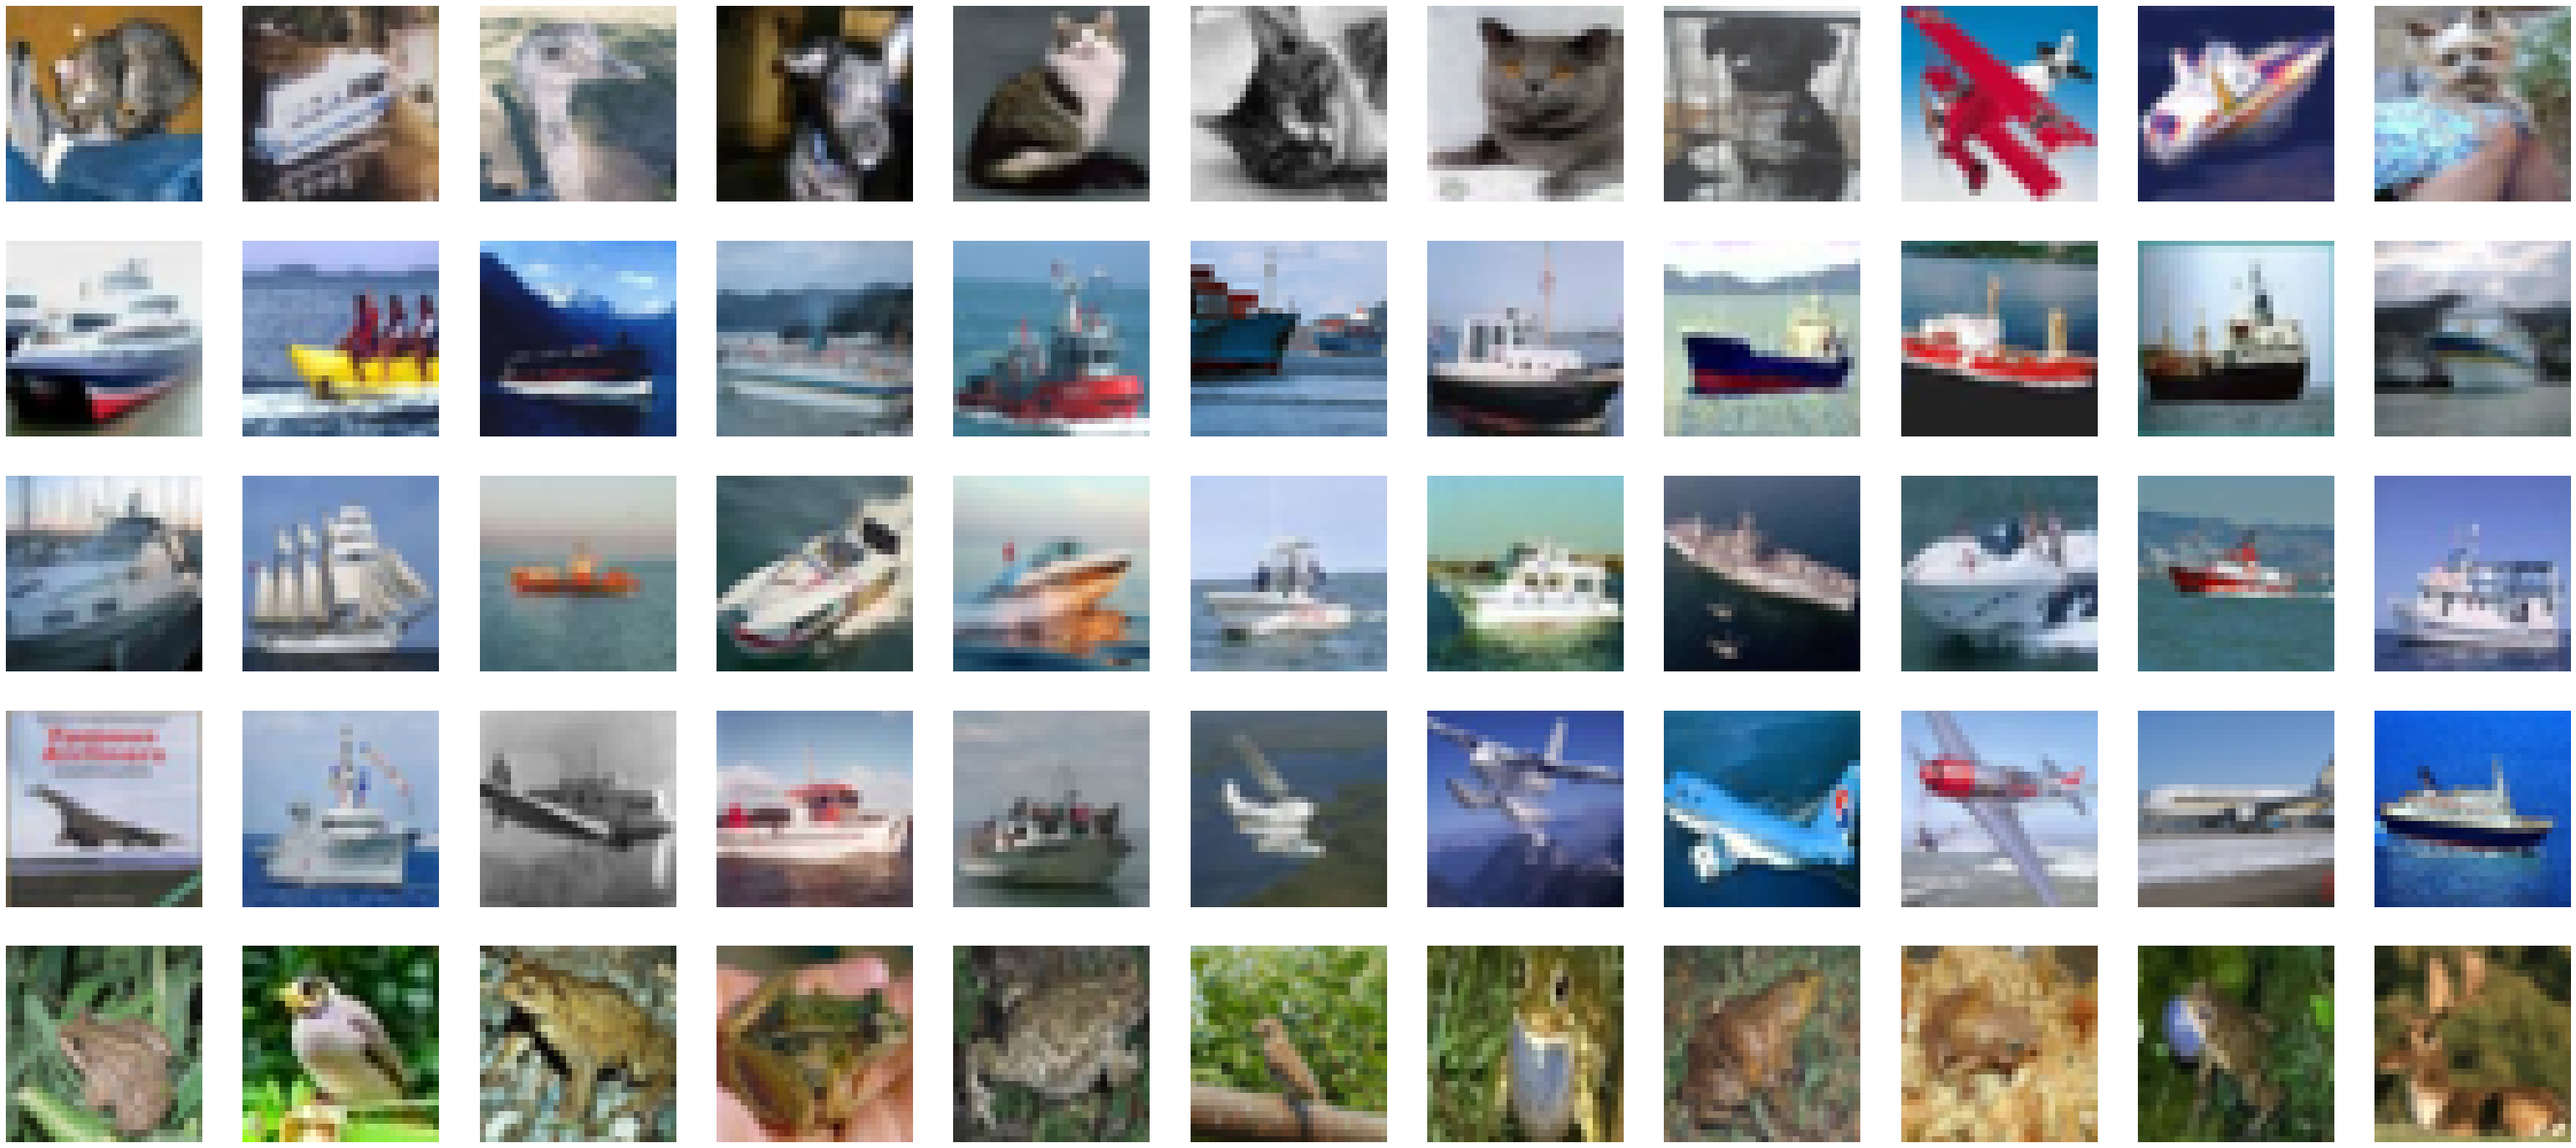

In [28]:
show_collage(examples)

# Visualize Result Matrix

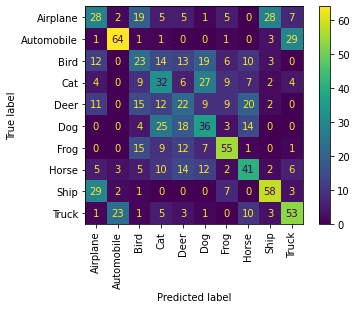

In [29]:
num_classes = len(testset.classes)
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = anchor_testset.class_idx_to_data_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = anchor_testset.targets[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [c.capitalize() for c in trainset.classes]

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, 
          cmap="viridis", 
          ax=None, 
          xticks_rotation="vertical")

plt.show()